In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pypsa

In [ ]:
n = pypsa.Network()

eta_el = 0.1
eta_dh = 0.8
eta_direct = 0.95

el_capital_cost = 1000 # EUR/kW
dh_capital_cost = 1000 # EUR/kW

eta = eta_direct / eta_dh

n.add(
    "Link",
    "geothermal CHP electricity",
    bus0='geothermal well',
    bus1='AC bus',
    efficiency=eta_el * (1. + eta),
    capital_cost=el_capital_cost * eta_el / (1 + eta),
    p_max_pu=0.5,
)
n.add(
    "Link",
    "geothermal CHP district heat",
    bus0='geothermal well',
    bus1='DH bus',
    efficiency=eta_dh * (1 + eta),
    capital_cost=dh_capital_cost * eta_dh / (1 + eta),
    p_max_pu=eta / 2.,
)

# Plus additional constraints

# 1. p_nom of both links equal                                           -> CHP operation
# 2. p_el > alpha p_dh                                                   -> backpressure limit
# 3. p_el = p_nom * (eta_direct - (p_dh / p_nom)) / (eta_direct - 1)     -> iso fuel

# recall p_nom = p_nom_el = p_nom_dh






In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 6))

ax.plot([0, 1], [1, 1,], color='red', label='ORC capacity', linewidth=2)


eta_dh = 0.8 # efficiency when heating with ORC waste heat
eta_direct = 0.95 # efficiency when heating directly with geothermal heat

e = eta_direct / eta_dh

ax.plot([1, e], [1, 0], color='blue', label='Iso fuel line', linewidth=2)

s = 0.2

m = 1 / (1 - e)
b = e / (e - 1)

x = b / (s - m)
y = x * s

ax.plot([0, x], [0, y], color='green', label='Backpressure Limit', linewidth=2, linestyle='dashed')
ax.axvline(0, color='black', linewidth=1)
ax.axhline(0, color='black', linewidth=1)

ax.set_xlabel("Heat Generation")
ax.set_ylabel("Power Generation")

fill_x = np.linspace(0, e, 100)
ax.fill_between(
    fill_x,
    np.zeros_like(fill_x),
    np.minimum(np.ones_like(fill_x), m*fill_x + b),
    color='red', alpha=0.2)

ax.text(1.2, 0.02, "A")
ax.text(1.01, 1.01, "B")

ax.legend()

ax.grid('dashed')
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(-0.05, 1.4)

plt.show()

##### Testing

In [40]:
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from pypsa.linopt import get_var, linexpr, define_constraints

n = pypsa.Network()
s = np.arange(30)

eta_el = 0.1
eta_dh = 0.8
eta_direct = 0.95

n.set_snapshots(s)

heat_demand = np.hstack([np.zeros(10), np.ones(20) * eta_dh])
elec_demand = np.hstack([np.ones(20) * eta_el, np.zeros(10)])

n.add("Bus", "well")
n.add("Bus", "district heat")
n.add("Bus", "AC")

n.add("Generator",
    "geothermal",
    bus="well",
    # p_nom_extendable=True,
    # p_nom_max=100,
    p_nom=2.,
    capital_cost=1
    )

n.add("Load", "heat load", bus="district heat", p_set=heat_demand)
n.add("Load", "elec load", bus="AC", p_set=elec_demand)

el_capital_cost = 1000 # EUR/kW
dh_capital_cost = 0.25 * el_capital_cost # EUR/kW

eta = eta_direct / eta_dh

n.add(
    "Link",
    "dh",
    bus0='well',
    bus1='district heat',
    carrier='dh',
    # efficiency=eta_dh * (1 + eta),
    efficiency=eta_dh,
    # capital_cost=dh_capital_cost * eta_dh / (1 + eta),
    capital_cost=dh_capital_cost * eta_dh,
    # p_max_pu=eta / 2.,
    p_nom_extendable=True,
    p_nom=0.,
)
n.add(
    "Link",
    "elec",
    bus0='well',
    bus1='AC',
    carrier='elec',
    # efficiency=eta_el * (1. + eta),
    efficiency=eta_el,
    # capital_cost=el_capital_cost * eta_el / (1 + eta),
    capital_cost=el_capital_cost * eta_el,
    # p_max_pu=0.5,
    # p_nom_extendable=True,
    p_nom=1.,
)


def extra_functionality(n, snapshots):

    elec_index = n.links.loc[n.links.carrier == 'elec'].index
    heat_index = n.links.loc[n.links.carrier == 'dh'].index

    p_nom_lhs = (
        n.model["Link-p_nom"].loc[heat_index]
        - n.model["Link-p_nom"].loc[elec_index]
	)


    n.model.add_constraints(
        p_nom_lhs == 0,
        name="equalizes_p_nom_of_chp_elec_and_chp_district_heat",
    )

    '''
    link_p = n.model["Link-p"].loc[elec_index]
    # define iso fuel lines
    link_p = get_var(n, "Link", "p")
    link_p_nom = get_var(n, "Link", "p_nom")

    lhs = linexpr(
        (1, link_p[elec_index]),
        (1, link_p[heat_index].values),
        (-1, link_p_nom[heat_index].values))

    define_constraints(n, lhs, "", 0, "egschplink", "egs_chp_top_iso_fuel_line")
    '''



# n.optimize(solver_name="gurobi", extra_functionality=extra_functionality)
n.optimize(solver_name="gurobi")

c:\Users\lukas\miniforge3\envs\pypsa-eur\lib\site-packages\linopy\expressions.py:176: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'Generator' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  ds = self.data.assign_coords({group_dim: idx})
c:\Users\lukas\miniforge3\envs\pypsa-eur\lib\site-packages\linopy\expressions.py:176: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'Link' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates

Restricted license - for non-production use only - expires 2024-10-28
Read LP format model from file C:\Users\lukas\AppData\Local\Temp\linopy-problem-ec4iz8cn.lp
Reading time = 0.03 seconds
obj: 271 rows, 91 columns, 361 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12650H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 271 rows, 91 columns and 361 nonzeros
Model fingerprint: 0xcfa20eaa
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [2e+02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+00]
Presolve removed 271 rows and 91 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0000000e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objec

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 91 primals, 271 duals
Objective: 2.00e+02
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


('ok', 'optimal')

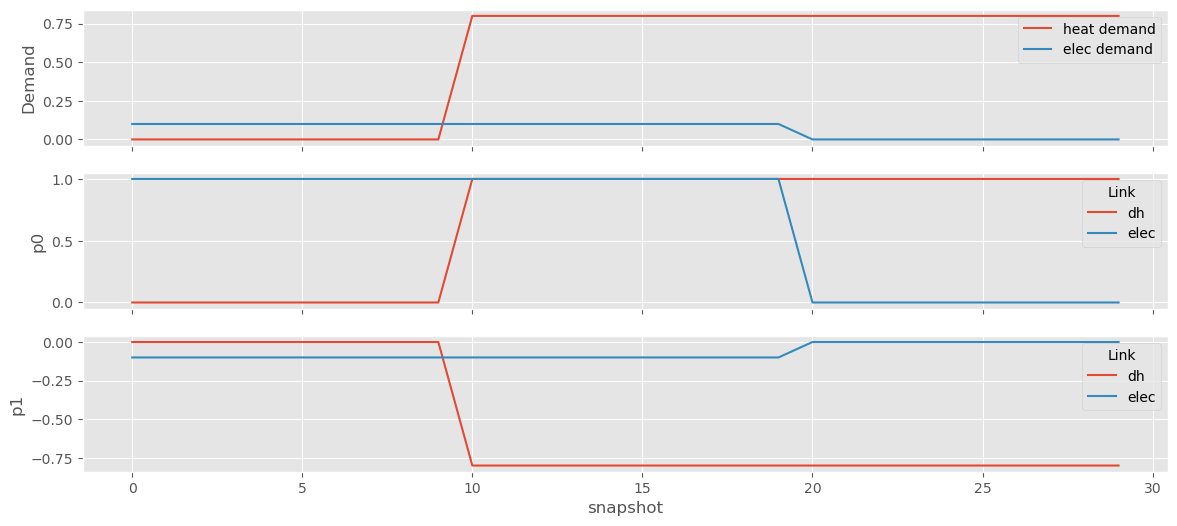

In [38]:
fig, axs = plt.subplots(3, 1, figsize=(14, 6), sharex=True)

axs[0].plot(s, heat_demand, label="heat demand")
axs[0].plot(s, elec_demand, label="elec demand")
axs[0].legend()

axs[0].set_ylabel("Demand")
axs[1].set_ylabel("p0")
axs[2].set_ylabel("p1")

n.links_t.p0.plot(ax=axs[1])
n.links_t.p1.plot(ax=axs[2])

plt.show()

In [39]:
n.links[["p_nom_opt", "capital_cost"]]

attribute,p_nom_opt,capital_cost
Link,,
dh,1.0,200.0
elec,1.0,100.0


<AxesSubplot:xlabel='snapshot'>

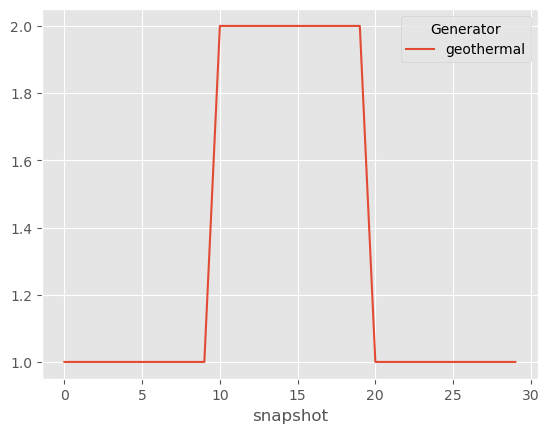

In [42]:
n.generators_t.p.

##### On efficiencies

paper

- Combined heat and power from hydrothermal geothermal resources in Germany: An assessment of the potential

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [43]:
Tin = [50, 60, 60, 70, 45, 45, 45, 50, 55, 70]
Twell = [160, 124, 122, 165, 138, 135, 140, 128, 118, 136]


In [48]:
print(np.mean(Tin))
print(np.mean(Twell))

diff = np.mean(Twell) - np.mean(Tin)

55.0
136.6


In [54]:
well_fr = 112.3 # kg/s

elec_fr = 20
c = 4200 # J/kgK
eta_el = 0.1
eta_th = 0.8
P = 4.5e6 # W

In [56]:
P / (elec_fr * c * eta)

45.112781954887225

In [62]:
165 * 4200 * 63

43659000

##### Towards understanding operable space

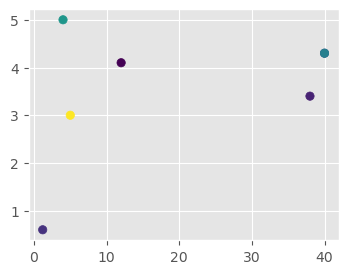

In [63]:
import matplotlib.pyplot as plt
import numpy as np

Pel = np.array([3, 0.6, 3.4, 5, 4.3, 4.1, 4.3])
Pth = np.array([5, 1.2, 38, 4, 40, 12, 40])
T = np.array([160, 124, 122, 140, 128, 118, 136])
dT = np.array([110, 64, 62, 95, 78, 63, 66])
frs = np.array([70, 23, 150, 110, 140, 165, 120])


fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(Pth, Pel, c=T, cmap='viridis')
plt.show()

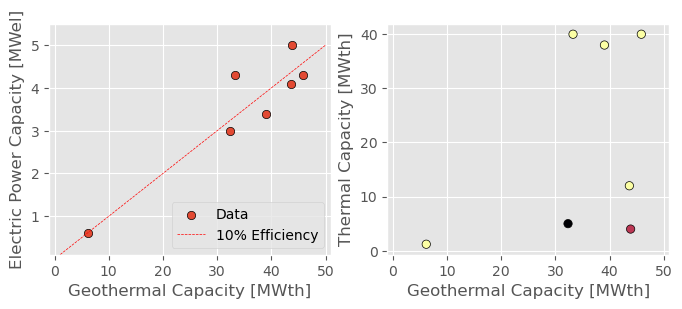

In [90]:
x = dT * frs * c * 1e-6
y = Pel 

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].scatter(
    x,
    y,
    edgecolor='black',
    linewidth=0.5,
    label='Data'
    )

parallel = [0, 1, 1, 0.5, 1, 1, 1]

axs[1].scatter(
    x,
    Pth,
    edgecolor='black',
    linewidth=0.5,
    label='Data',
    c=parallel,
    cmap='inferno',
    )

hx = np.linspace(0, 50, 2)
hy = 0.1 * hx

axs[0].plot(
    hx,
    hy,
    color='red',
    label='10% Efficiency',
    linewidth=0.5,
    linestyle='dashed'
    )

for ax in axs:
    ax.set_xlim(-1, 51)

axs[0].set_ylim(0.1, 5.5)

axs[0].set_xlabel("Geothermal Capacity [MWth]")
axs[1].set_xlabel("Geothermal Capacity [MWth]")

axs[0].set_ylabel("Electric Power Capacity [MWel]")
axs[1].set_ylabel("Thermal Capacity [MWth]")

axs[0].legend(loc='lower right')

plt.show()

In [1]:
a = ['1332', 'nf', 'fgnn']
a

['1332', 'nf', 'fgnn']